# 贷款预测之EDA

In [1]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

from matplotlib import pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')

import pickle

In [247]:
# train = pd.read_csv('../dataset/train.csv', header=0, index_col='Loan_ID')
with open('new_data.pkl', 'rb') as f:
    train = pickle.load(f)

In [248]:
# 目标变量
target_var = 'Loan_Status'

# 分类变量

# 连续变量
num_col = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
           'Loan_Amount_Term','TotalIncome', 'FamilySize',
           'AverageIncome', 'Repayment']

cat_col = [x for x in train.columns if x not in num_col and x != target_var]

In [221]:
train.dropna(axis=0, inplace=True)

In [179]:
new_num_col = []
for col in num_col:
    name = col+'_'+'squra'
    new_num_col.append(name)
    train[name] = np.power(train[col], 2)

In [180]:
for col in num_col:
    name = col+'_'+'sqrt'
    new_num_col.append(name)
    train[name] = np.sqrt(train[col])

In [222]:
coapplicant = train.loc[train['CoapplicantIncome']>0, :].copy()

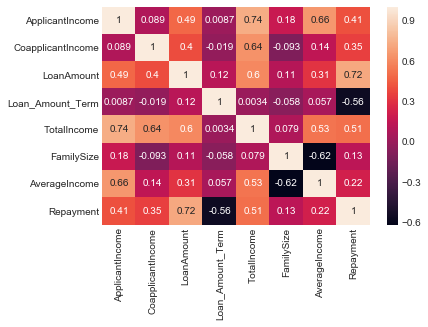

In [223]:
corr = np.log1p(coapplicant[num_col]).corr()
sns.heatmap(corr, annot=True)

In [224]:
y = coapplicant[target_var].copy()
X = coapplicant.drop([target_var], axis=1)

In [225]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

X = pd.get_dummies(X, columns=['Property_Area', 'Dependents'])
X[num_col] = X[num_col].apply(lambda x:np.log1p(x))


In [234]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=45)

In [226]:
from sklearn.preprocessing import StandardScaler

In [235]:
std_scaler = StandardScaler()
for col in num_col:
    std_scaler.fit(X_train[col].values.reshape(-1,1))
    X_train[col] = std_scaler.transform(X_train[col].values.reshape(-1,1))
    X_test[col] = std_scaler.transform(X_test[col].values.reshape(-1,1))

In [236]:
from sklearn.preprocessing import LabelEncoder

label_enc = LabelEncoder()
for col in ['Gender', 'Married', 'Education', 'Self_Employed']:
    label_enc.fit(X_train[col].values.reshape(-1,1))
    X_train[col] = label_enc.transform(X_train[col].values.reshape(-1,1))
    X_test[col] = label_enc.transform(X_test[col].values.reshape(-1,1))

In [237]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test= np.array(y_test)

In [246]:
from mlxtend.classifier import LogisticRegression
lr = LogisticRegression(eta=0.15, 
                        l2_lambda=0.0, 
                        epochs=150,
                        minibatches=5, # for Gradient Descent
                        random_seed=1,
                        print_progress=3)
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

Iteration: 150/150 | Cost 115.60 | Elapsed: 0:00:00 | ETA: 0:00:00

0.84999999999999998

In [242]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=45)
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.8125

In [240]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=45, n_estimators=500)
rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.84999999999999998

In [207]:
pd.DataFrame({'coef':rf.feature_importances_, 'col':X_train.columns.tolist()})\
             .sort_values(by='coef', ascending=False)

,coef,col
8,0.195591,Credit_History
25,0.046657,TotalIncome_sqrt
17,0.044352,TotalIncome_squra
9,0.044022,TotalIncome
28,0.042634,Repayment_sqrt
20,0.041439,Repayment_squra
19,0.041410,AverageIncome_squra
27,0.041275,AverageIncome_sqrt
11,0.040437,AverageIncome
15,0.039086,LoanAmount_squra


从上表，大概可以看出每个分类变量的值有几种，最多的是哪类。<br><br>


## 变量分析

### 连续变量分析

In [22]:
for col in num_col:
    print('{}, skew={}'.format(col, train[col].skew()))

Dependents, skew=0.9422716157450567
ApplicantIncome, skew=6.917026514199138
CoapplicantIncome, skew=5.881622127841592
LoanAmount, skew=2.3614368477871213
Loan_Amount_Term, skew=-2.333710422255636
TotalIncome, skew=5.93135682683205
FamilySize, skew=0.9422716157450567
AverageIncome, skew=3.8069612683591973
Repayment, skew=4.847206233694799


In [23]:
log_numerical = train.copy()
log_numerical[num_col] = log_numerical[num_col].apply(lambda x: np.log1p(x))

In [24]:
for col in num_col:
    print('{}, skew={}'.format(col, log_numerical[col].skew()))

Dependents, skew=0.6039997860122087
ApplicantIncome, skew=0.5651441603527614
CoapplicantIncome, skew=-0.15010350243127799
LoanAmount, skew=-0.3755444512878643
Loan_Amount_Term, skew=-3.94281715815386
TotalIncome, skew=0.9353550158207503
FamilySize, skew=0.6987462675744456
AverageIncome, skew=0.13470553799156681
Repayment, skew=2.4270435836244273


In [25]:
from scipy.stats import ttest_ind
from statsmodels.stats.weightstats import ztest
def get_p_value(data, columns, target):
    s1 = data.loc[data[target]==data[target].unique()[0], columns]
    s2 = data.loc[data[target]==data[target].unique()[1], columns]
    if len(s1)>30 and len(s2)>30:
        z, p = ztest(s1, s2)
    else:
        t, p = ttest_ind(s1, s2)
    return p

In [39]:
stats_result = pd.DataFrame(columns=['pvalue', 'P<0.05', 'col'])
for col in num_col:
    p = get_p_value(coapplicant, col, target_var)
    stats_result.loc[len(stats_result)] = [p, p<0.05, col]
stats_result.sort_values(by='pvalue', ascending=True)

,pvalue,P<0.05,col
3,0.001110,True,LoanAmount
8,0.005964,True,Repayment
2,0.013548,True,CoapplicantIncome
5,0.022432,True,TotalIncome
7,0.270702,False,AverageIncome
4,0.315114,False,Loan_Amount_Term
1,0.339265,False,ApplicantIncome
0,0.850571,False,Dependents
6,0.850571,False,FamilySize


In [28]:
def plot_num(data, feature_name):
    s1 = data.loc[data[target_var]==1, feature_name]
    s2 = data.loc[data[target_var]==0, feature_name]
    s1mean = s1.mean()
    s1std = s1.std()
    s2mean = s2.mean()
    s2std = s2.std()
    print('Loan_Status==Yes, the mean={:.2f}(+/-{:.2f})'.format(s1mean, s1std))
    print('Loan_Status==No, the mean={:.2f}(+/-{:.2f})'.format(s2mean, s2std))
    if s1mean>s2mean:
        delta = s1mean-s2mean
    else:
        delta = s2mean-s1mean
    print('Absolute Mean Diferrence Distance: {:.2f}'.format(delta))
    print('p-value: {}'.format(stats_result.loc[stats_result['col']==feature_name, 'pvalue'].values[0]))
    print('p<0.05: {}'.format(stats_result.loc[stats_result['col']==feature_name, 'P<0.05'].values[0]))
    if feature_name in num_col:
        plt.figure(figsize=(15,5))
        _ = plt.subplot2grid((2,2),(0,0), rowspan=2)
        sns.pointplot(x=target_var, y=feature_name, data=data)
        
        _ = plt.subplot(2,2,2)
        sns.boxplot(y=feature_name, x=target_var, data=data)
        
        _ = plt.subplot(2,2,4)
        sns.kdeplot(data=data.loc[data[target_var]==1, feature_name], label='Y', shade=True)
        sns.kdeplot(data=data.loc[data[target_var]==0, feature_name], label='N', shade=True)
    else:
        plt.figure(figsize=(15,5))
        _ = plt.subplot2grid((2,2),(0,0), rowspan=2)
        sns.pointplot(x=target_var, y=feature_name, data=data)
        
        _ = plt.subplot(2,2,2)
        sns.boxplot(y=feature_name, x=target_var, data=data)
        
        _ = plt.subplot(2,2,4)
        sns.countplot(x=data.loc[data[target_var]==1, feature_name], data=df_train, color='darkgray')
        sns.countplot(x=data.loc[data[target_var]==0, feature_name], data=df_train, color='yellow')

### 分类变量分析

In [33]:
def get_chi2_value(data, columns, target=target_var):
    crosstable = pd.crosstab(data[columns], data[target])
    chi2, p, dof, expected = chi2_contingency(crosstable)
    return p

In [34]:
from scipy.stats import chi2_contingency
chi2_result = pd.DataFrame(columns=['pvalue', 'P<0.05', 'col'])
for col in cat_col:
    crosstable = pd.crosstab(coapplicant[col], log_numerical[target_var])
    chi2, p, dof, expected = chi2_contingency(crosstable)
    chi2_result.loc[len(chi2_result)] = [p, p<0.05, col]
chi2_result.sort_values(by='pvalue', ascending=True)

,pvalue,P<0.05,col
5,2.006034e-19,True,Credit_History
4,9.889225e-03,True,Property_Area
2,1.668006e-01,False,Education
1,2.647247e-01,False,Married
0,4.557400e-01,False,Gender
3,5.145754e-01,False,Self_Employed


分类变量比连续变量情况好，Credit_History， Property_Area和Married与目标变量统计不独立，其他分类变量与目标变量统计不显著，不相关。

In [14]:
def plot_cat(data, feature_name):
    p = get_chi2_value(data, feature_name)
    crosstable = pd.crosstab(data[feature_name], data[target_var])
#     chi2, p, dof, expected = chi2_contingency(crosstable)
    # 不同特征值间离职和未离职的比例
    crosstable = crosstable.div(crosstable.sum(1), axis=0).round(4)
    crosstable.columns = ['No', 'Yes']
    print('\n 分类比例')
    print(crosstable)
    
    # 不同特征值在总体样本中所在比例
    percentage = (data[feature_name].value_counts() / len(data)).round(4)
    # 累计比例
    cumsum = percentage.cumsum().round(4)
    
    
    counttable = pd.DataFrame({'percentage': percentage, 'cumsum':cumsum},
                              index=data[feature_name].value_counts().index,
                              columns=['percentage', 'cumsum'])
    print('\n计数比例')
    print(counttable)
    
    yes_table = data[data[target_var]==1].groupby(feature_name)[target_var].sum()
    yes_percentage = (yes_table/yes_table.sum()).round(4)
    yestable = pd.DataFrame({'percentage': yes_percentage},
                            index=yes_table.index)
    yestable2 = yestable.reindex(index=counttable.index)
    yestable2['cumsum'] = yestable2['percentage'].cumsum()
    print('\n申请成功')
    print(yestable2)
    
    plt.figure(figsize=(15,7))
    ax1 = plt.subplot(2,2,1) # plt.subplot2grid((2,2),(0,0), rowspan=2)
    crosstable.plot(kind='bar', stacked=True, ax=ax1, rot=0)
    ax1.set_ylim([0,1.1])
    
    _ = plt.subplot(2,2,3)
    sns.barplot(x=feature_name, y=target_var, data=data, errwidth=0)
        
    _ = plt.subplot(2,2,2)
    sns.countplot(x=feature_name, data=data)

    _ = plt.subplot(2,2,4)
    sns.countplot(x=feature_name, data=data, hue=target_var)

## 组合变量分析
### TotolIncome

In [16]:
log_numerical.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,TotalIncome
Loan_ID,,,,,,,,,,,,,
LP001003,Male,Yes,1,Graduate,No,8.430327,7.319202,4.859812,5.888878,1.0,Rural,0,15.749530
LP001005,Male,Yes,0,Graduate,Yes,8.006701,0.000000,4.204693,5.888878,1.0,Urban,1,8.006701
LP001006,Male,Yes,0,Not Graduate,No,7.857094,7.765993,4.795791,5.888878,1.0,Urban,1,15.623087
LP001008,Male,No,0,Graduate,No,8.699681,0.000000,4.955827,5.888878,1.0,Urban,1,8.699681
LP001011,Male,Yes,2,Graduate,Yes,8.597482,8.342125,5.590987,5.888878,1.0,Urban,1,16.939607


Loan_Status==Yes, the mean=12.75(+/-3.62)
Loan_Status==No, the mean=12.25(+/-3.87)
Absolute Mean Diferrence Distance: 0.51
p-value: 0.16385801663828437
p<0.05: False


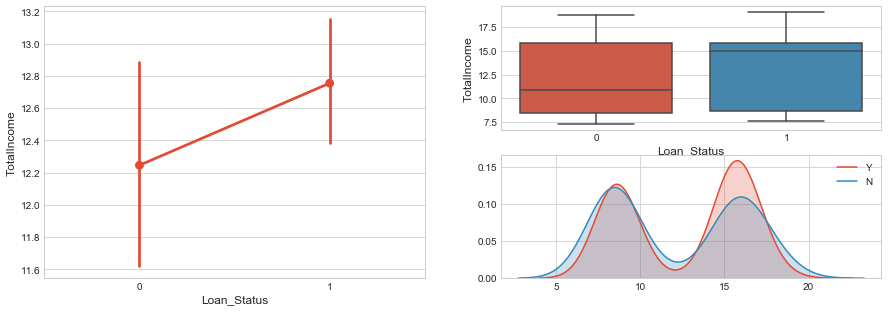

In [21]:
# num_col.append('TotalIncome')
log_numerical['TotalIncome'] = log_numerical['ApplicantIncome'] + log_numerical['CoapplicantIncome']
p = get_p_value(log_numerical, 'TotalIncome', target_var)
stats_result.loc[len(stats_result)] = [p, p<0.05, 'TotalIncome']
plot_num(log_numerical, 'TotalIncome')

#### TotolIncome & Property_Area

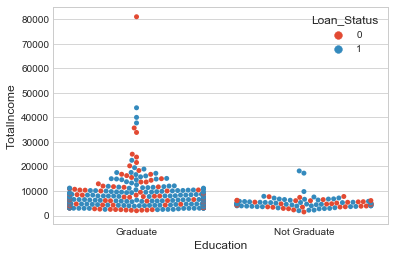

In [281]:
sns.swarmplot(x='Education', y='TotalIncome', data=train, hue=target_var)


Gender<-->Married
Married        No       Yes
Gender                     
Female   0.471458  0.528542
Male     0.461641  0.538359

Gender<-->Dependents
Dependents         0         1         2        3+
Gender                                            
Female      0.232558  0.219269  0.182724  0.365449
Male        0.247957  0.235303  0.276648  0.240091

Gender<-->Education
Education  Graduate  Not Graduate
Gender                           
Female     0.471014      0.528986
Male       0.540793      0.459207

Gender<-->Self_Employed
Self_Employed        No       Yes
Gender                           
Female         0.564706  0.435294
Male           0.508479  0.491521

Gender<-->Property_Area
Property_Area     Rural  Semiurban     Urban
Gender                                      
Female         0.305556   0.391414  0.303030
Male           0.296621   0.382896  0.320483

Gender<-->Credit_History
Credit_History       0.0       1.0
Gender                            
Female          0.088452

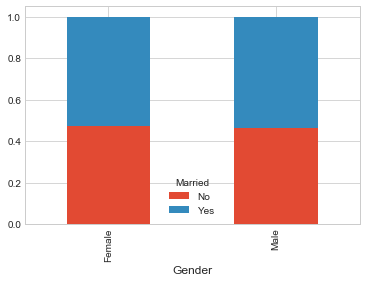

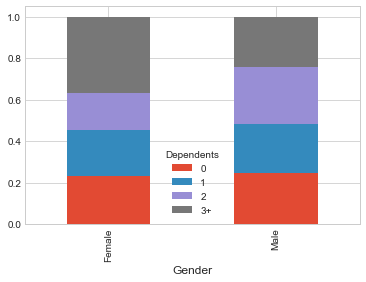

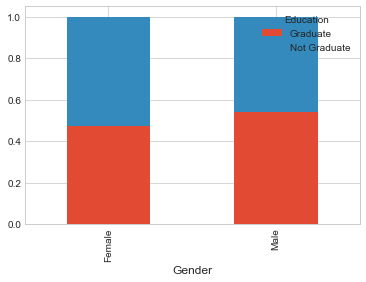

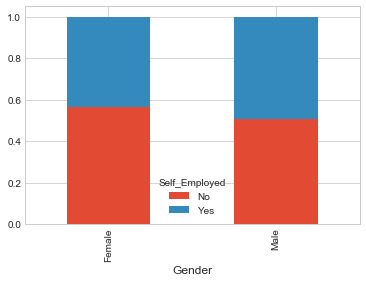

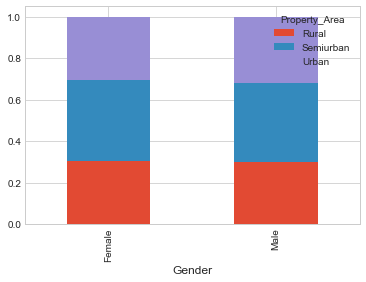

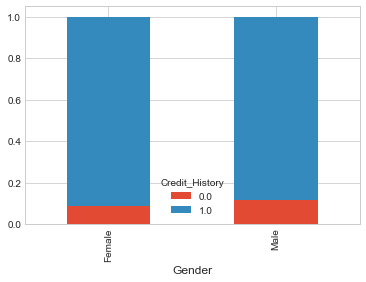

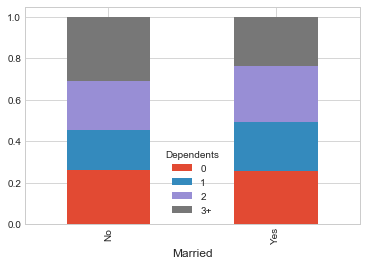

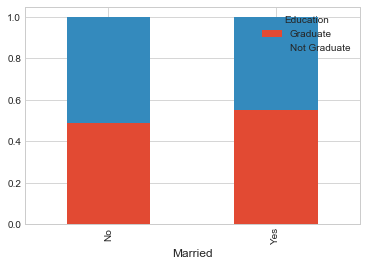

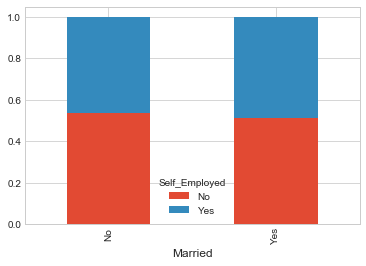

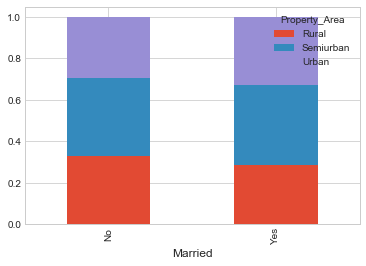

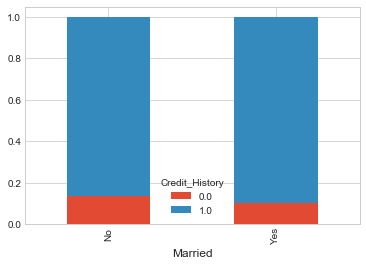

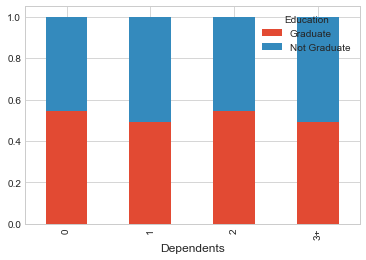

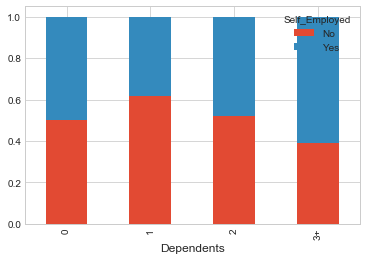

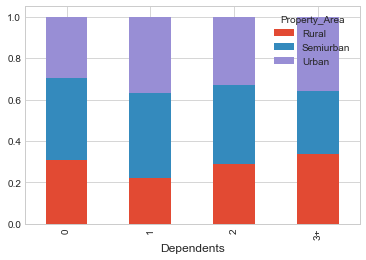

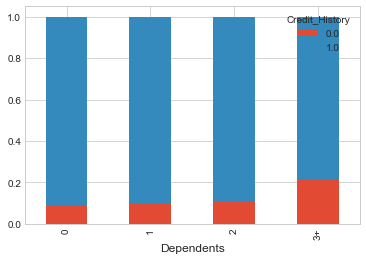

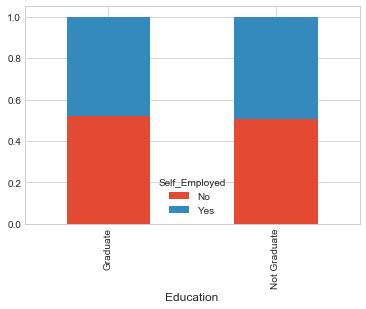

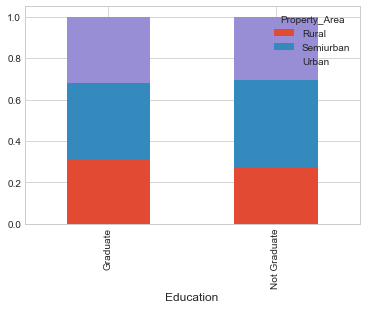

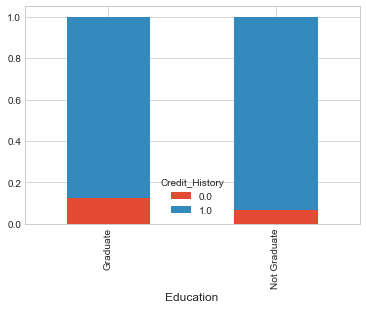

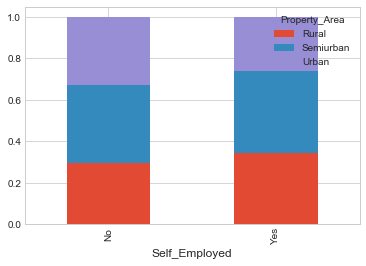

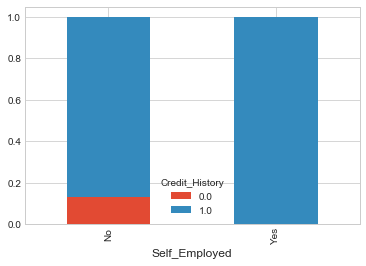

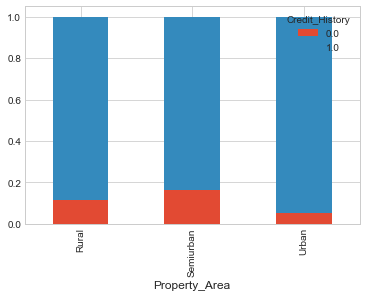

In [22]:
n = len(cat_col)
for x in range(n):
    for y in range(x, n):
        if x>=y: continue
        pivotable = pd.pivot_table(index=cat_col[x], columns=cat_col[y], values=target_var, data=log_numerical)
        pivotable = pivotable.div(pivotable.sum(1), axis=0)
        print('\n{}<-->{}'.format(cat_col[x], cat_col[y]))
        print(pivotable)
        pivotable.plot(kind='bar',stacked=True)

Loan_Status==Yes, the mean=6.04(+/-2.61)
Loan_Status==No, the mean=6.25(+/-2.61)
Absolute Mean Diferrence Distance: 0.21
p-value: 0.41980603563522545
p<0.05: False


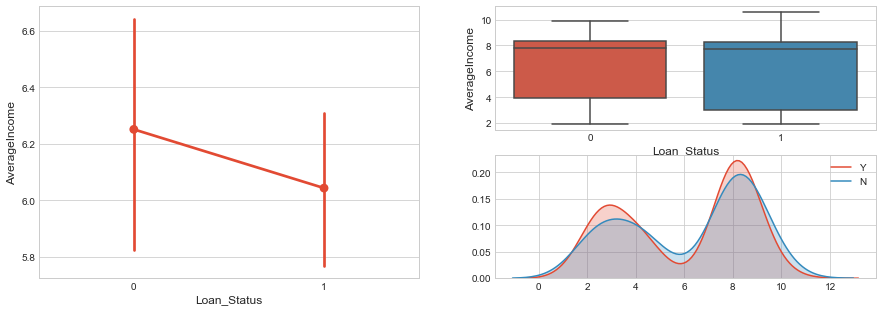

In [24]:
log_numerical['Dependents'] = log_numerical['Dependents'].map({'3+':3, '2':2, '1':1, '0':0})
log_numerical['FamilySize'] = log_numerical['Dependents']+1
log_numerical['AverageIncome'] = log_numerical['ApplicantIncome'] / log_numerical['FamilySize']
num_col.extend(['FamilySize', 'AverageIncome'])
p = get_p_value(log_numerical, 'AverageIncome', target_var)
stats_result.loc[len(stats_result)] = [p, p<0.05, 'AverageIncome']
plot_num(log_numerical, 'AverageIncome')

In [284]:
num_col

['ApplicantIncome',
 'CoapplicantIncome',
 'LoanAmount',
 'Loan_Amount_Term',
 'TotalIncome',
 'FamilySize',
 'AverageIncome']

Loan_Status==Yes, the mean=0.83(+/-0.09)
Loan_Status==No, the mean=0.85(+/-0.11)
Absolute Mean Diferrence Distance: 0.01
p-value: 0.14060038127210644
p<0.05: False


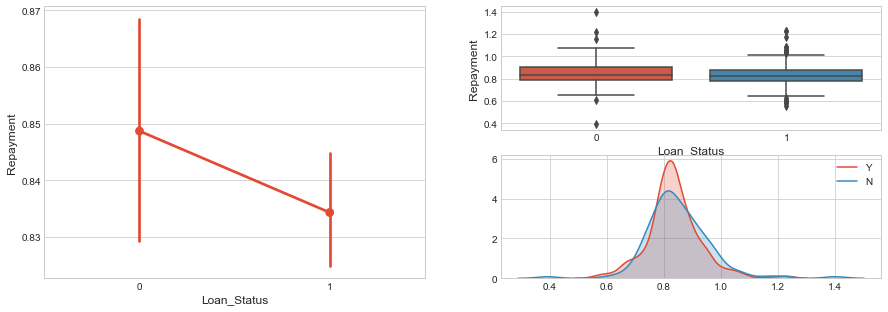

In [25]:
num_col.append('Repayment')
log_numerical['Repayment'] = log_numerical['LoanAmount'] / log_numerical['Loan_Amount_Term']
p = get_p_value(log_numerical, 'Repayment', target_var)
stats_result.loc[len(stats_result)] = [p, p<0.05, 'Repayment']
plot_num(log_numerical, 'Repayment')

In [286]:
train.describe(percentiles=[.1, .9])

,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,TotalIncome,FamilySize,AverageIncome,Repayment
count,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000
mean,0.777083,5364.231250,1581.093583,144.735417,342.050000,0.854167,0.691667,6945.324833,1.777083,3719.610417,0.459267
std,1.020815,5668.251251,2617.692267,80.508164,65.212401,0.353307,0.462287,5969.948374,1.020815,3584.903384,0.367847
min,0.000000,150.000000,0.000000,9.000000,36.000000,0.000000,0.000000,1442.000000,1.000000,150.000000,0.025000
10%,0.000000,2238.800000,0.000000,70.000000,294.000000,0.000000,0.000000,3179.300000,1.000000,1069.891667,0.208333
50%,0.000000,3859.000000,1084.500000,128.000000,360.000000,1.000000,1.000000,5422.500000,1.000000,2742.000000,0.366667
90%,2.000000,9511.000000,3797.000000,234.200000,360.000000,1.000000,1.000000,11508.000000,3.000000,6963.500000,0.763889
max,3.000000,81000.000000,33837.000000,600.000000,480.000000,1.000000,1.000000,81000.000000,4.000000,39147.000000,4.305556


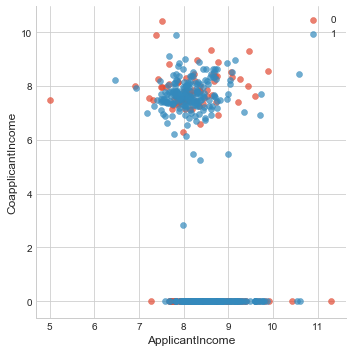

In [23]:
g = sns.FacetGrid(log_numerical, hue=target_var, size=5)
g.map(plt.scatter, 'ApplicantIncome', 'CoapplicantIncome', alpha=0.7)
plt.legend()

In [288]:
no_coapplicant = train.loc[train['CoapplicantIncome']>0,:].copy()

In [289]:
stats_result = pd.DataFrame(columns=['pvalue', 'P<0.05', 'col'])
for col in num_col:
    p = get_p_value(no_coapplicant, col, target_var)
    stats_result.loc[len(stats_result)] = [p, p<0.05, col]
stats_result.sort_values(by='pvalue', ascending=True)

,pvalue,P<0.05,col
2,0.001110,True,LoanAmount
7,0.005964,True,Repayment
1,0.013548,True,CoapplicantIncome
4,0.022432,True,TotalIncome
6,0.270702,False,AverageIncome
3,0.315114,False,Loan_Amount_Term
0,0.339265,False,ApplicantIncome
5,0.850571,False,FamilySize


Loan_Status==Yes, the mean=139.59(+/-58.30)
Loan_Status==No, the mean=170.45(+/-90.78)
Absolute Mean Diferrence Distance: 30.86
p-value: 0.0011103581054301924
p<0.05: True
Loan_Status==Yes, the mean=0.43(+/-0.27)
Loan_Status==No, the mean=0.54(+/-0.32)
Absolute Mean Diferrence Distance: 0.11
p-value: 0.005963957199979967
p<0.05: True
Loan_Status==Yes, the mean=2599.52(+/-1990.90)
Loan_Status==No, the mean=3594.74(+/-4556.88)
Absolute Mean Diferrence Distance: 995.22
p-value: 0.013547563727454762
p<0.05: True
Loan_Status==Yes, the mean=6551.62(+/-4035.28)
Loan_Status==No, the mean=7981.96(+/-5698.18)
Absolute Mean Diferrence Distance: 1430.34
p-value: 0.022432489146205603
p<0.05: True


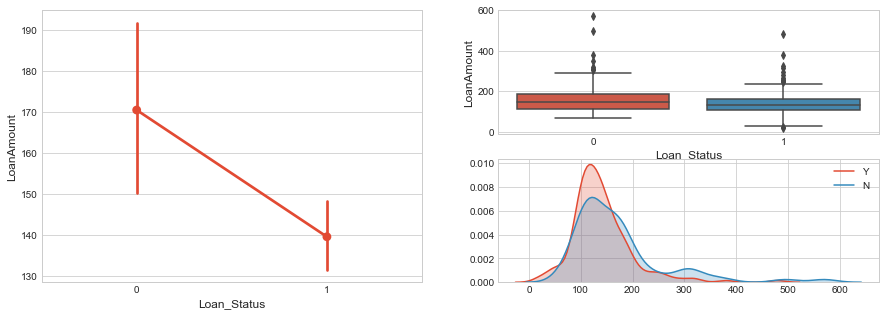

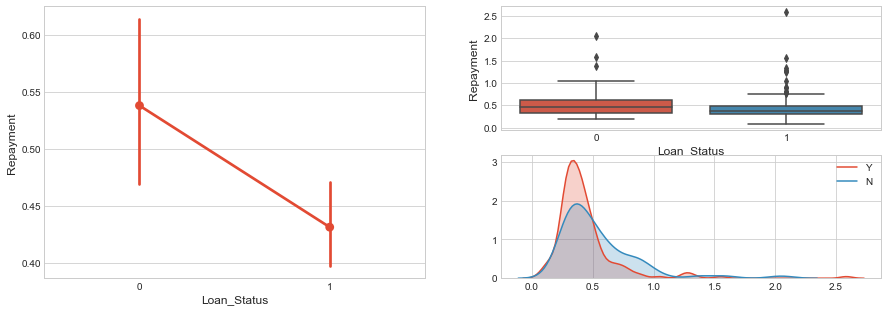

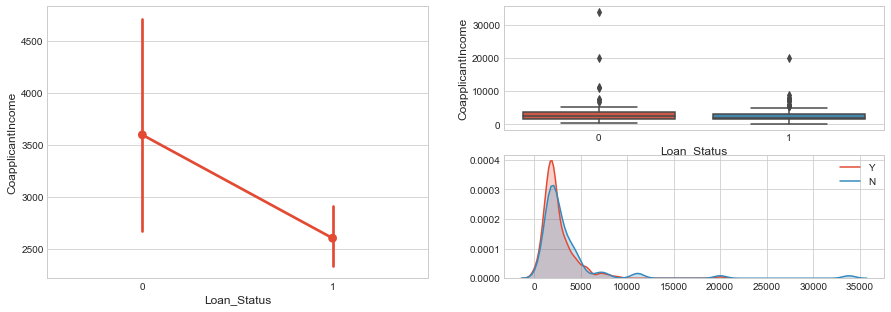

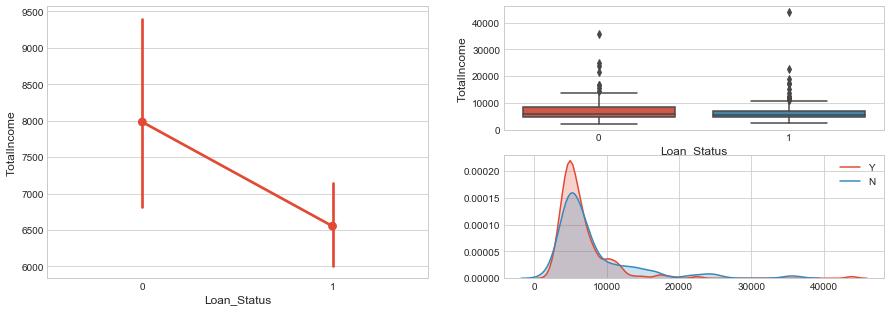

In [290]:
plot_num(no_coapplicant, 'LoanAmount')
plot_num(no_coapplicant, 'Repayment')
plot_num(no_coapplicant, 'CoapplicantIncome')
plot_num(no_coapplicant, 'TotalIncome')


Gender<-->Married
Married        No       Yes
Gender                     
Female   0.432990  0.567010
Male     0.478332  0.521668

Gender<-->Dependents
Dependents         0         1         2         3
Gender                                            
Female      0.285714  0.476190  0.238095       NaN
Male        0.265109  0.238214  0.300150  0.196527

Gender<-->Education
Education  Graduate  Not Graduate
Gender                           
Female     0.566038      0.433962
Male       0.538767      0.461233

Gender<-->Self_Employed
Self_Employed        No       Yes
Gender                           
Female         1.000000  0.000000
Male           0.521428  0.478572

Gender<-->Property_Area
Property_Area     Rural  Semiurban     Urban
Gender                                      
Female         0.306122   0.489796  0.204082
Male           0.293658   0.380020  0.326322

Gender<-->Credit_History
Credit_History       0.0       1.0
Gender                            
Female          0.210526

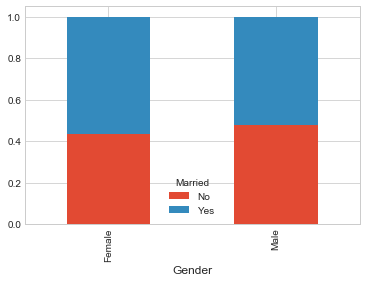

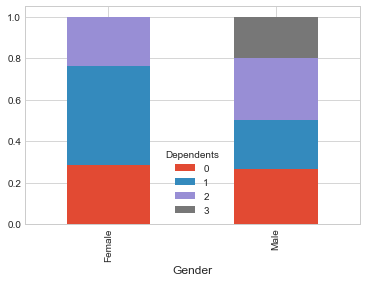

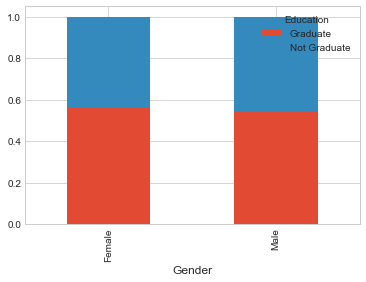

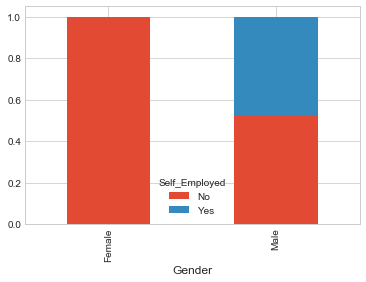

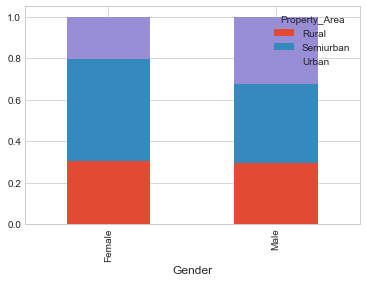

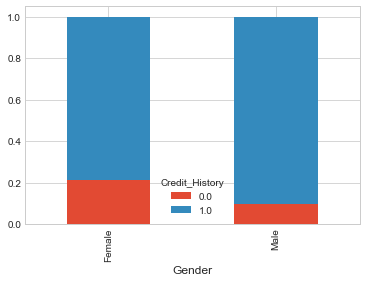

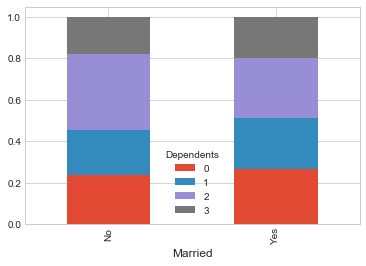

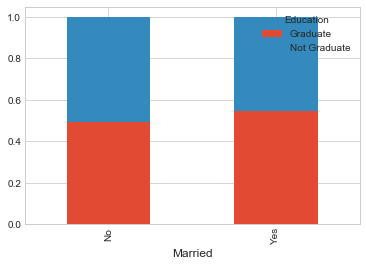

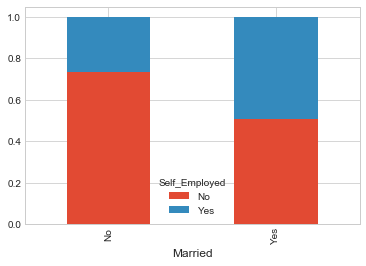

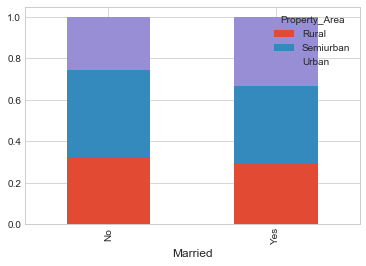

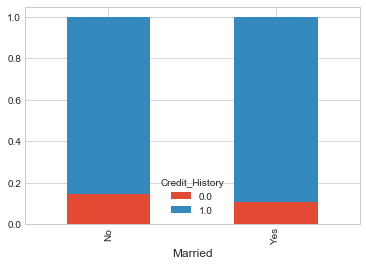

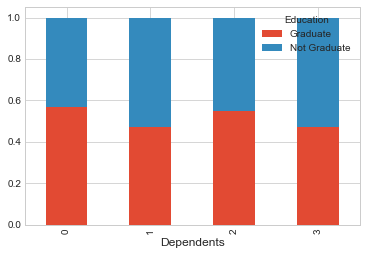

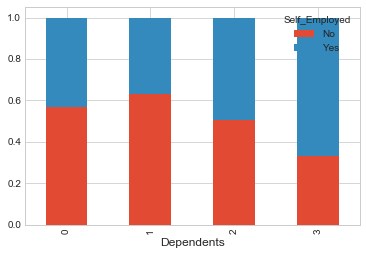

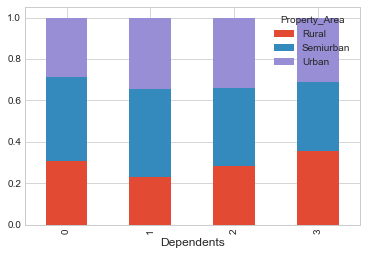

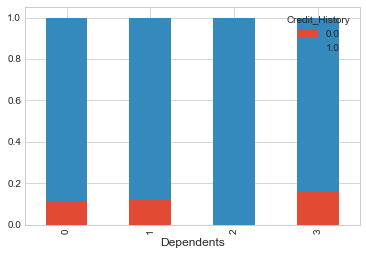

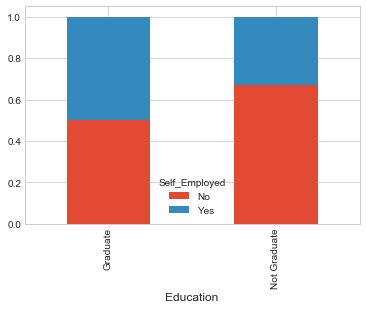

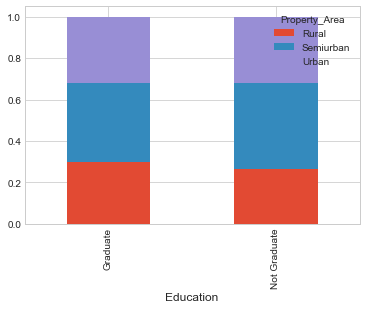

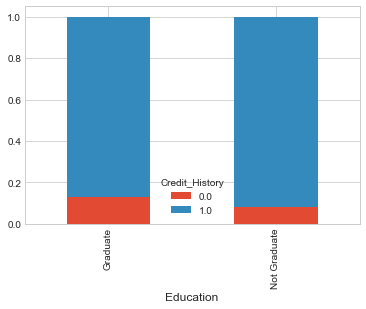

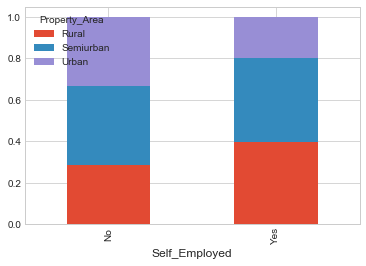

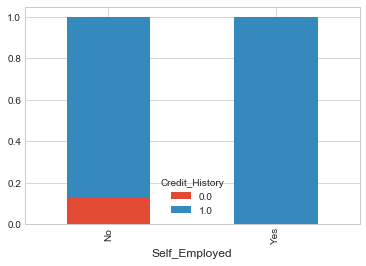

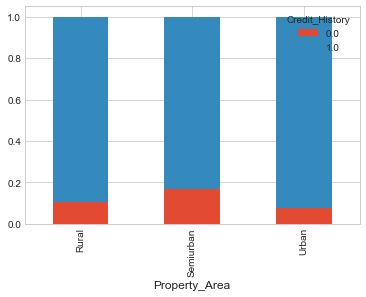

In [291]:
n = len(cat_col)
for x in range(n):
    for y in range(x, n):
        if x>=y: continue
        pivotable = pd.pivot_table(index=cat_col[x], columns=cat_col[y], values=target_var, data=no_coapplicant)
        pivotable = pivotable.div(pivotable.sum(1), axis=0)
        print('\n{}<-->{}'.format(cat_col[x], cat_col[y]))
        print(pivotable)
        pivotable.plot(kind='bar',stacked=True)

In [292]:
chi2_result = pd.DataFrame(columns=['pvalue', 'P<0.05', 'col'])
for col in cat_col:
    crosstable = pd.crosstab(no_coapplicant[col], train[target_var])
    chi2, p, dof, expected = chi2_contingency(crosstable)
    chi2_result.loc[len(chi2_result)] = [p, p<0.05, col]
chi2_result.sort_values(by='pvalue', ascending=True)

,pvalue,P<0.05,col
6,2.006034e-19,True,Credit_History
5,9.889225e-03,True,Property_Area
2,1.067600e-01,False,Dependents
3,1.668006e-01,False,Education
1,2.647247e-01,False,Married
0,4.557400e-01,False,Gender
4,5.145754e-01,False,Self_Employed


In [293]:
train.columns

Index(['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
       'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status',
       'TotalIncome', 'FamilySize', 'AverageIncome', 'Repayment'],
      dtype='object')

In [295]:
np.save('new_data.npy', train)

## 缺失值的处理

In [ ]:
# 将字符变量转化为数值型
le = LabelEncoder()
not_missing_var = [x for x in cat_cal+num_col if sum(df[x].isnull())==0\
                                         and x in cat_cal]
for col in not_missing_var:
    df[col] = le.fit_transform(df[col])

用随机森林对缺失值进行填充。

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import time
def fill_miss_var(df):
    predictors = [x for x in cat_cal+num_col if sum(df[x].isnull())==0]
    
    missing_var = [x for x in cat_cal+num_col if sum(df[x].isnull())!=0]
    
    for outcome in missing_var:
        #Fit the model:
        clf = RandomForestClassifier(random_state=45, n_estimators=50, n_jobs=-1)
        
        train_df = df[df[outcome].notnull()]
        test_df = df[df[outcome].isnull()]
    
        clf.fit(train_df[predictors],train_df[outcome])
    
        #Make predictions on training set:
        predictions = clf.predict(test_df[predictors]) 
        df.loc[df[outcome].isnull(),outcome]=predictions
    
    return df

df = fill_miss_var(df)

In [ ]:
df.head()

In [ ]:
# 为分类变量创建虚拟变量
for col in categories_var:
    dummies = pd.get_dummies(data=df[col],prefix=col)
    dummies.drop([dummies.iloc[:,0].name], axis=1, inplace=True)
    df = pd.concat([df,dummies],axis=1)
    df.drop([col],axis=1,inplace=True)
    
# 将连续变量标准化
stand_enc = StandardScaler()

for col in continuities_var:
    df[col] = stand_enc.fit_transform(np.array(df[col]).reshape(-1,1).astype(float64))

## 建立模型
用Skicit-Learn（sklearn）建立机器学习模型。
sklearn要求所有的输入都是数值型，所以首先需要对数据集进行编码。

In [ ]:
# 定义预测和验证函数
def classification_model(model,df,predictor,outcome):
    X_train, X_test, y_train, y_test = train_test_split(df[predictor], df[outcome], test_size=0.3)
    
    model.fit(X_train, y_train)
    result = model.predict(X_test)
    score = model.score(X_test, y_test)
    print('预测准确率是:%.4f'%score)
    report = metrics.classification_report(y_test, result)
    print('='*50)
    print('验证报告')
    print(report)
    matrix = metrics.confusion_matrix(y_test, result)
    print('='*50)
    print('混淆矩阵:')
    print(matrix)
    
    # 输出预测错的样本
    df = pd.read_csv('./dataset/train_set.csv', header=0, index_col='Loan_ID')
    bad_index = y_test.loc[result != y_test].index.tolist()
    bad_cases = df.loc[bad_index, :]
    return model, bad_cases

def predictor_result(clf,df,predictors):
    target = clf.predict(df[predictors])
    result = DataFrame({'Loan_Status':target}, index=df.index)
    result.to_csv('Submissions.csv')

In [ ]:
train_df = df.loc[df['source']=='train'].copy()
test_df = df.loc[df['source']=='test'].copy()

train_df.drop(['source'], axis=1, inplace=True)
test_df.drop(['source'], axis=1, inplace=True)

### Logistic回归

In [ ]:
predictor_var=[x for x in train_df.columns if x !=target_var]
model = LogisticRegression(C=1, penalty='l1', tol=1e-6)
clf, badbases = classification_model(model, train_df, predictor_var, target_var)
#pd.DataFrame({"columns":predictor_var, "coef":list(clf.coef_.T)})

In [ ]:
predictor_result(clf, test_df, predictor_var)

上传结果，得分是** <font color='red'>0.7847</font> **，不算很差。<br>
这个只是没有做任何特征提取和特征工程的baseline，看看其他人的结果，应该还有提升的空间。<br>
现在分析baseline模型拟合情况，绘制学习曲线。

In [ ]:
va.plot_learning_curve(model, 'lr', train_df[predictor_var], train_df[target_var])

从学习曲线上看，baseline模型没有处于过拟合的状态，还可以在做一些特征提取和特征工程，添加新的特征到模型中。<br>
观察模型得到的各个特征的系数，因为系数能够展现特征与预测结果的关系及关系强弱。

In [ ]:
coef = pd.DataFrame({"columns":predictor_var, "coef":list(clf.coef_[0])})
coef.to_csv('coef.csv')

从系数的绝对值大小依次分析，
1. Credit_History_0.0对结果的影响最大，并且是负相关，也就是说，如果Credit_History = 0， 预测结果更可能是0；
2. 其次是Property_Area,房产的位置也会影响到贷款申请，可能是因为不同区域的房产，价格不一样，能够提供的担保不一样，这个变量也可以再挖掘；
3. Married与否和结果分别是正负相关，因此这个结果结论也可以深挖；
4. Dependents_1与结果是负相关，其他值对结果没有影响，但是在单变量分析的时候，没有发现各个值之间有很大的变化，也许是挖掘不够；
5. Education与Married一样，分别是正负相关；
6. 三个连续特征对结果的影响不大；
7. 只有Self_Employed_Yes对结果有影响，应该也需要和其他特征结合，生成新变量；
8. 性别对结果完全没有影响，这个和前面的变量分析是一致的；
9. 只有Loan_Amount_Term_180.0和Loan_Amount_Term_480.0对结果有影响。

结合系数的分析，可以尝试：
1. 将ApplicantIncome和CoapplicantIncome相加，求总的收入；
2. 

In [ ]:
train_df = pd.read_csv('./dataset/train_set.csv', header=0, index_col='Loan_ID')
test_df = pd.read_csv('./dataset/test_set.csv', header=0, index_col='Loan_ID')

train_df['source'] = 'train'
test_df['source'] = 'test'

df = pd.concat([train_df, test_df],axis=0)

train_df['Loan_Status'] = train_df['Loan_Status'].map({'Y':1,'N':0}).astype('int32')

In [ ]:
df.dropna(inplace=True)
for col in categories_var:
    df[col] = le.fit_transform(df[col])

fig = plt.figure(figsize=(8,8))
sns.heatmap(df[continuities_var].corr(), annot=True)

从上图看出，ApplicantIncome和LoanAmount的相关系数是0.5，说明两者存在一定的正相关。

In [ ]:
g = sns.FacetGrid(df, size=5)
g.map(plt.scatter, 'ApplicantIncome', 'LoanAmount', alpha=0.7)

从上图可以看出，ApplicantIncome和LoanAmount呈线性关系，并且ApplicantIncome没有缺失值，可以用ApplicantIncome来预测LoanAmount的值。<br>
申请贷款时，如果是综合收入也许和贷款金额有一些关系，因此考虑ApplicantIncome+CoapplicantIncome的情况。在上面的单变量分析中，ApplicantIncome，CoapplicantIncome和LoanAmount都不是正态分布，而且有离群值存在，因此作对数变换。

In [ ]:
df['TotalIncome'] = np.log(df['ApplicantIncome'] + df['CoapplicantIncome'])
df['LoanAmount'] = np.log(df['LoanAmount']*1000)
g = sns.FacetGrid(df, size=5)
(g.map(plt.scatter, 'TotalIncome', 'LoanAmount', alpha=0.7)).add_legend()

In [ ]:
# 用线性回归方式填充LoanAmount
from sklearn.linear_model import LinearRegression
clf = LinearRegression()
X_train = np.array(df.loc[df['LoanAmount'].isnull()==False, 'TotalIncome']).reshape(-1,1)
y_train = np.array(df.loc[df['LoanAmount'].isnull()==False, 'LoanAmount']).reshape(-1,1)
X_test = np.array(df.loc[df['LoanAmount'].isnull()==True, 'TotalIncome']).reshape(-1,1)
clf.fit(X_train, y_train)
df.loc[df['LoanAmount'].isnull()==True, 'LoanAmount'] = clf.predict(X_test)

In [ ]:
df['Credit_History'].fillna(df['Credit_History'].mode()[0], inplace=True)
df['Dependents'].fillna(df['Dependents'].mode()[0], inplace=True)
df['Gender'].fillna(df['Gender'].mode()[0], inplace=True)
df['LoanAmount'].fillna(df['LoanAmount'].mean(), inplace=True)
df['Loan_Amount_Term'].fillna(df['Loan_Amount_Term'].mode()[0], inplace=True)
df['Married'].fillna(df['Married'].mode()[0], inplace=True)
df['Self_Employed'].fillna(df['Self_Employed'].mode()[0], inplace=True)

df['Dependents'] = le.fit_transform(df['Dependents'])
df['Dependents'] = df['Dependents']+1
df['Property_Area'] = le.fit_transform(df['Property_Area'])
df['Property_Area'] = df['Property_Area'] + 1
df['TotalIncome'] = (df['ApplicantIncome'] + df['CoapplicantIncome'])*df['Property_Area']
df['return']=df['LoanAmount']*1000/df['Loan_Amount_Term']
df['temp']=df['TotalIncome']/df['Dependents']
df['radio']=df['temp']/df['return']
#df[['return', 'temp', 'radio', 'Loan_Amount_Term', 'Loan_Status','Dependents']]

In [ ]:
train_df = df.loc[df['source']=='train'].copy()
#train_df['Dependents'] = le.fit_transform(train_df['Dependents'])
g = sns.FacetGrid(train_df, hue='Loan_Status', size=8)
(g.map(plt.scatter, 'temp', 'return', alpha=0.3)).add_legend()
#sns.violinplot(x='Property_Area', y='radio', hue='Loan_Status', data=train_df, split=True)

In [ ]:
df['Credit_History'].fillna(df['Credit_History'].mode(), inplace=True)
df['Dependents'].fillna(df['Dependents'].mode(), inplace=True)
df['Gender'].fillna(df['Gender'].mode(), inplace=True)
df['LoanAmount'].fillna(df['LoanAmount'].mean(), inplace=True)
df['Loan_Amount_Term'].fillna(df['Loan_Amount_Term'].mode(), inplace=True)
df['Married'].fillna(df['Married'].mode(), inplace=True)
df['Self_Employed'].fillna(df['Self_Employed'].mode(), inplace=True)

# 总收入
df['TotalIncome'] = df['ApplicantIncome'] + df['CoapplicantIncome']
df['IncomeBand'] = pd.qcut(df['TotalIncome'], q=[.25,.5,.75,1])

df['AmountBand'] = pd.qcut(df['LoanAmount'], q=[.25,.5,.75,1])

df['radio'] = df['TotalIncome']/(df['LoanAmount'] * 1000.0 / df['Loan_Amount_Term'])

#continuities_var.append('TotalIncome')
#continuities_var.append('radio')
#for col in continuities_var:
#    df[col] = stand_enc.fit_transform(np.array(df[col]).reshape(-1,1).astype(float64))


df.drop(['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'TotalIncome'], axis=1, inplace=True)


columns = [x for x in df.columns if x not in [target_var, 'source']]
for col in columns:
    dummies = pd.get_dummies(data=df[col],prefix=col)
    df = pd.concat([df,dummies],axis=1)
    df.drop([col],axis=1,inplace=True)
#
#df.drop(['Credit_History_1.0'],axis=1,inplace=True)
#df.drop(['Gender_Female'], axis=1, inplace=True)
#df.drop(['Married_Yes'], axis=1, inplace=True)
#df.drop(['Dependents_3+'], axis=1, inplace=True)
#df.drop(['Education_Graduate'], axis=1, inplace=True)
#df.drop(['Self_Employed_No'], axis=1, inplace=True)
#df.drop(['Property_Area_Semiurban'], axis=1, inplace=True)
#df.drop(['Loan_Amount_Term_6.0'], axis=1, inplace=True)

In [ ]:
df.head(2)

In [ ]:
train_df = df.loc[df['source']=='train'].copy()
test_df = df.loc[df['source']=='test'].copy()

train_df.drop(['source'], axis=1, inplace=True)
test_df.drop(['source'], axis=1, inplace=True)

In [ ]:
predictor_var=[x for x in train_df.columns if x !=target_var]
model = LogisticRegression(C=0.1, penalty='l1', tol=1e-6)
clf, badbases = classification_model(model, train_df, predictor_var, target_var)

In [ ]:
def urban(area):
    a, b = area
    return 0 if a == 1 and b == 1 else 1
df['Urban'] = df[['Credit_History_0.0','Property_Area_2']].apply(urban, axis=1)

In [ ]:
train_df = df[df['source']=='train']
test_df = df[df['source']=='test']

train_df.drop(['source'], axis=1, inplace=True)
test_df.drop(['source'], axis=1, inplace=True)

In [ ]:
predictor_var=[x for x in train_df.columns if x !=target_var]
model = LogisticRegression(C=1,penalty='l1', tol=1e-6)
clf = classification_model(model,train_df,predictor_var,target_var)

根据不同特征的权重值，在模型上：
* Credit_History 与结果是强正相关，即有贷款历史的申请者更容易申请到贷款。
* LoanAmount和Loan_Amount_Term与结果是负相关，即贷款量越小，贷款期限越短，越容易申请到贷款。Loan_Amount_Term的影响比LoanAmount更小。
* 学历高对贷款状态的影响不明显，但是低学历会影响到贷款状态。
* 居住在Semiurban更容易获得贷款，Rural和Urban对和状态是负相关。
* Dependents=1时不容易获得贷款。
* 性别和结果都是负相关，因此性别对结果的影响不大。
* 未婚申请者的申请成功概率更低。
* Self_Employed对结果没有影响。
* TotalIncome和结果是正相关。

In [ ]:
param_test1 = {'C':[0.1,0.5,1,5,10]}
gsearch1 = GridSearchCV(estimator = \
                        LogisticRegression(penalty='l1',tol=1e-6),param_grid=param_test1,cv=5)
gsearch1.fit(train_df[predictor_var],train_df[outcome_var])
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

In [ ]:
param_test1 = {'verbose':range(0,5,1),'tol':[1e-2,1e-3,1e-4,1e-5,1e-6,1e-7,1e-8],'C':[0.1,0.5,1,5,10],
              'random_state':range(0,20,2)}
gsearch1 = GridSearchCV(estimator = LogisticRegression(penalty='l1'),
                        param_grid=param_test1,
                        cv=5)
gsearch1.fit(train_df[predictor_var],train_df[outcome_var])
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

In [ ]:
model = LogisticRegression(C=10,penalty='l1',tol=1e-6,random_state=10)

In [ ]:
from sklearn.svm import LinearSVC
model = LinearSVC(random_state=0)